In [1]:
import sys
sys.path.append('/workspace/Documents')
# imports
import os, sys
import numpy as np 
import pandas as pd
import random
import nibabel as nb
import cv2
import ast
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from skimage.measure import block_reduce

import Diffusion_motion_field.Build_lists.Build_list as Build_list
import Diffusion_motion_field.functions_collection as ff
import Diffusion_motion_field.Data_processing as Data_processing

main_path = '/mnt/camca_NAS/4DCT/pictures'

### picture to show that direct synthesis of 4DCT is not a good idea

In [12]:
save_folder = os.path.join(main_path, 'illustration_of_direct_synthesis_of_4DCT')
ff.make_folder([save_folder])
patient_class = 'Pull_2'
patient_id = 'case_72'
shape = nb.load(os.path.join('/mnt/camca_NAS/4DCT/mgh_data/nii-images',patient_class,patient_id,'img-nii-resampled-1.5mm/0.nii.gz')).get_fdata().shape
print('original shape:', shape)

original shape: (99, 99, 79)


In [16]:
slice_n = 48
WL = -220
WW = 1770
# original resolution
img_ori = nb.load(os.path.join('/mnt/camca_NAS/4DCT/reference/',patient_class, patient_id, 'image_original/0.nii.gz')).get_fdata()[:,:,slice_n]
img_ori = Data_processing.crop_or_pad(img_ori, [100,100], np.min(img_ori))
img_down = block_reduce(image=img_ori, block_size=(4,4), func=np.mean)
img_down_up = zoom(img_down, (4, 4), order=1)

ff.save_grayscale_image(np.flip(img_ori.T,axis = 0),os.path.join(save_folder,'img_ori.png'), WL=WL, WW=WW)
ff.save_grayscale_image(np.flip(img_down.T,axis = 0),os.path.join(save_folder,'img_down.png'), WL=WL, WW=WW)
ff.save_grayscale_image(np.flip(img_down_up.T,axis = 0),os.path.join(save_folder,'img_down_up.png'), WL=WL, WW=WW)

### showcase motion vector field

In [38]:
save_folder = os.path.join(main_path, 'illustration_of_MVF')
ff.make_folder([save_folder])
patient_class = 'Pull_2'
patient_id = 'case_72'
mvf = nb.load(os.path.join('/mnt/camca_NAS/4DCT/mvf_warp0_onecase', patient_class, patient_id, 'voxel_final/0.nii.gz')).get_fdata()
print(mvf.shape)

(160, 160, 96, 3)


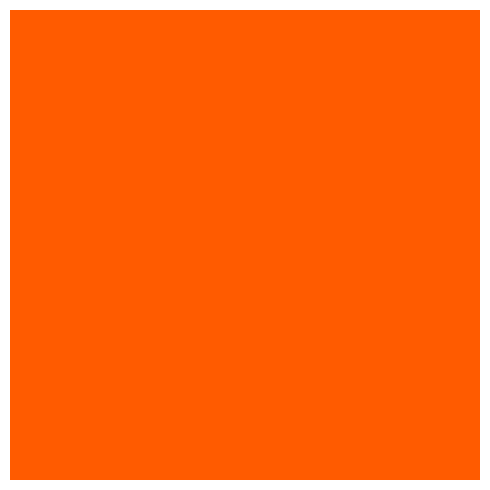

In [42]:
# plot x
slice_n = 48
mvf_x = mvf[:,:,slice_n,0]; mvf_x = Data_processing.crop_or_pad(mvf_x, [100,100], np.min(mvf_x))

mvf_x = block_reduce(image=mvf_x, block_size=(4,4), func=np.mean)
# mvf_x = np.zeros_like(mvf_x)

plt.figure(figsize=(5, 5))
im = plt.imshow(mvf_x.T, cmap='hot', origin='lower' ,vmin = -5, vmax = 5)  # 'jet' or 'viridis' are common
plt.axis('off')
# plt.colorbar(im, label='Displacement (voxel)')
# plt.title('X-direction Motion Vector Field')
# plt.xlabel('X')
# plt.ylabel('Y')
plt.tight_layout()
# plt.show()
plt.savefig(os.path.join(save_folder, 'mvf_t0_downsampled.pdf'),format = 'pdf', bbox_inches='tight',pad_inches=0)



In [26]:
# show that downsampled MVF can faithfully represent original MVF
# image_warped_mvf_original is by applying original MVF
# image_warped_mvf_down_up is by applying downsampled-then-upsample MVF
slice_n = 48
WL = -220
WW = 1770
img_ori = nb.load(os.path.join('/mnt/camca_NAS/4DCT/reference/',patient_class, patient_id, 'image_warped_mvf_original/6.nii.gz')).get_fdata()[:,:,slice_n]
img_ori = Data_processing.crop_or_pad(img_ori, [100,100], np.min(img_ori))

img_down_up  = nb.load(os.path.join('/mnt/camca_NAS/4DCT/reference/',patient_class, patient_id, 'image_warped_mvf_down_up/6.nii.gz')).get_fdata()[:,:,slice_n]
img_down_up = Data_processing.crop_or_pad(img_down_up, [100,100], np.min(img_down_up))
ff.save_grayscale_image(np.flip(img_ori.T,axis = 0),os.path.join(save_folder,'img_warped_mvf_original.png'), WL=WL, WW=WW)
ff.save_grayscale_image(np.flip(img_down_up.T,axis = 0),os.path.join(save_folder,'img_warped_mvf_down_up.png'), WL=WL, WW=WW)

img_diff = abs(img_down_up - img_ori)
mae = np.mean(img_diff)
print('mae:', mae)
ff.save_grayscale_image(np.flip(img_diff.T,axis = 0),os.path.join(save_folder,'img_diff.png'), WL=WL, WW=WW)

### Voxelmorph

In [43]:
save_folder = os.path.join(main_path, 'illustration_of_Voxelmorph')
ff.make_folder([save_folder])
patient_class = 'Pull_2'
patient_id = 'case_72'
slice_n = 48
WL = -220
WW = 1770


img_ori_ed = nb.load(os.path.join('/mnt/camca_NAS/4DCT/reference/',patient_class, patient_id, 'image_original/0.nii.gz')).get_fdata()[:,:,slice_n]
img_ori_ed = Data_processing.crop_or_pad(img_ori_ed, [100,100], np.min(img_ori_ed))

img_ori_es = nb.load(os.path.join('/mnt/camca_NAS/4DCT/reference/',patient_class, patient_id, 'image_original/6.nii.gz')).get_fdata()[:,:,slice_n]
img_ori_es = Data_processing.crop_or_pad(img_ori_es, [100,100], np.min(img_ori_es))

img_es_by_mvf = nb.load(os.path.join('/mnt/camca_NAS/4DCT/reference/',patient_class, patient_id, 'image_warped_mvf_original/6.nii.gz')).get_fdata()[:,:,slice_n]
img_es_by_mvf = Data_processing.crop_or_pad(img_es_by_mvf, [100,100], np.min(img_es_by_mvf))

ff.save_grayscale_image(np.flip(img_ori_ed.T,axis = 0),os.path.join(save_folder,'img_ori_ed.png'), WL=WL, WW=WW)
ff.save_grayscale_image(np.flip(img_ori_es.T,axis = 0),os.path.join(save_folder,'img_ori_es.png'), WL=WL, WW=WW)
ff.save_grayscale_image(np.flip(img_es_by_mvf.T,axis = 0),os.path.join(save_folder,'img_es_by_mvf.png'), WL=WL, WW=WW)

### Diffusion model

In [64]:
# # illustration
# save_folder = os.path.join(main_path, 'illustration_of_diffusion_model')
# ff.make_folder([save_folder])
# patient_class = 'Pull_2'
# patient_id = 'case_72'
# mvf = nb.load(os.path.join('/mnt/camca_NAS/4DCT/mvf_warp0_onecase', patient_class, patient_id, 'voxel_final/6.nii.gz')).get_fdata()
# print(mvf.shape)

# # plot x
# slice_n = 48
# mvf_x = mvf[:,:,slice_n,0]; mvf_x = Data_processing.crop_or_pad(mvf_x, [100,100], np.min(mvf_x))
# mvf_x = block_reduce(image=mvf_x, block_size=(4,4), func=np.mean)
# # add random noise 
# mvf_x = mvf_x + np.random.rand(*mvf_x.shape)*2

# # # pure noise
# # mvf_x = np.random.randn(*mvf_x.shape) * 1.1
# # # print('range of mvf_x:', np.min(mvf_x), np.max(mvf_x))
# # mvf_x = np.clip(mvf_x, -4, 4)

# plt.figure(figsize=(5, 5))
# im = plt.imshow(mvf_x.T, cmap='hot', origin='lower' ,vmin = -5, vmax = 5)  # 'jet' or 'viridis' are common
# plt.axis('off')
# # plt.colorbar(im, label='Displacement (voxel)')
# # plt.title('X-direction Motion Vector Field')
# # plt.xlabel('X')
# # plt.ylabel('Y')
# plt.tight_layout()
# # plt.show()
# plt.savefig(os.path.join(save_folder, 'gaussian.pdf'),format = 'pdf', bbox_inches='tight',pad_inches=0)



In [ ]:
# conditional input